In [51]:

!pip install transformers
!pip install langdetect
!pip install vaderSentiment
!pip install torch
!pip install wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.9 MB/s eta 0:00:00a 0:00:01m


# Exploratory Analysis of Incentive on the Opening of Olympics 2024

This notebook aims to perform an exploratory analysis of the sentiment of comments related to the video of the opening of the Olympics 2024 (https://www.youtube.com/watch?v=j-Ou-ggS718). At the time of this workbook's creation it has been watched 1,5 million times with 3861 comments.

Two methods for sentiment analysis will be used when the project is finalized: VADER and Hugging Face Transformers, and compare the results.


## Data Collection

The data for this analysis was collected using the Google YouTube API. The following steps were taken to obtain the data:

1. **API Setup**: 
   - Created a project on the Google Cloud Platform and enabled the YouTube Data API v3.
   - Generated an API key to authenticate requests to the YouTube API.

2. **Data Extraction**:
   - Used the API to fetch comments from YouTube videos related to the opening of the Olympics 2024.
   - Extracted relevant information such as the comment text, author, and publication date.

3. **Data Storage**:
   - Stored the extracted data in a CSV file named `youtube_olympics_comments.csv` for further analysis.


## Data Description

The dataset contains the following features:

- **Comment**: The text of the comment made by a user on the YouTube video.
- **Author**: The display name of the author who made the comment.
- **PublishedAt**: The date and time when the comment was published.
- **LikeCount**: The number of likes that the comment has received.

In [111]:
# Setup and Imports

# General imports
import pandas as pd
import matplotlib.pyplot as plt

# Language detection
from langdetect import detect, DetectorFactory
import langdetect.lang_detect_exception

# VADER for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Hugging Face Transformers for sentiment analysis
from transformers import pipeline

# Ensure consistent results from langdetect
DetectorFactory.seed = 0

from wordcloud import WordCloud, STOPWORDS

import string
from collections import Counter
from nltk.corpus import stopwords
import nltk

In [18]:
# Data Loading and Initial Exploration
youtube_olympics_comments=pd.read_csv('youtube_olympics_comments.csv')


In [22]:
youtube_olympics_comments.shape

(2536, 4)

In [29]:
youtube_olympics_comments.head

<bound method NDFrame.head of                                                 Comment                Author  \
0     Boycotting the Olympics! Drag degenerate show ...        @edgarsdzerins   
1                                    30:00-30:20 hmm...  @almantsakeldams3777   
2     THIS IS A DEMORALISATION PSYOP. BOTH DE-MORAL-...             @Bd-ng1zv   
3     Worst opening ever to be created, the world go...          @yanomosh123   
4     the internationalist banker sect is strong wit...             @Bd-ng1zv   
...                                                 ...                   ...   
2531                                   The silver horse               @CFVSAB   
2532                       My god Celine what was that?               @CFVSAB   
2533  <a href="https://www.youtube.com/watch?v=j-Ou-...          @SocialClout   
2534  Damn that was probably the most impressive ope...            @shugielov   
2535  Super performance türkiye team türkiye🇹🇷 note:...      @KartalKahraman1  

In [31]:
youtube_olympics_comments.describe()

,LikeCount
count,2536.000000
mean,10.080836
std,52.044164
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,1023.000000


In [33]:
youtube_olympics_comments['Author'].describe()

count       2529
unique      2275
top       @dyawr
freq          18
Name: Author, dtype: object

It seems some people have left multiple comments.

In [35]:
youtube_olympics_comments['LikeCount'].describe()

count    2536.000000
mean       10.080836
std        52.044164
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max      1023.000000
Name: LikeCount, dtype: float64

There is a comment that has received 1023 likes. What type (positive/negative/neutral) will be seen later.

Many comments are not in English. To make the task easier, all "non-en" are filtered out below.

In [37]:
## to filter only english comments


def is_english(comment):
    try:
        return detect(comment) == 'en'
    except langdetect.lang_detect_exception.LangDetectException:
        return False

# Filter out non-English comments
youtube_olympics_comments_english = youtube_olympics_comments[youtube_olympics_comments['Comment'].apply(is_english)]


In [39]:
youtube_olympics_comments_english

,Comment,Author,PublishedAt,LikeCount
0,Boycotting the Olympics! Drag degenerate show ...,@edgarsdzerins,2024-07-28T09:44:42Z,0
2,THIS IS A DEMORALISATION PSYOP. BOTH DE-MORAL-...,@Bd-ng1zv,2024-07-28T09:43:58Z,0
3,"Worst opening ever to be created, the world go...",@yanomosh123,2024-07-28T09:43:18Z,0
4,the internationalist banker sect is strong wit...,@Bd-ng1zv,2024-07-28T09:43:04Z,0
6,Satanic games. My country should not be there.,@user-gl1tc7wi8g,2024-07-28T09:40:05Z,0
...,...,...,...,...
2531,The silver horse,@CFVSAB,2024-07-26T21:36:33Z,21
2532,My god Celine what was that?,@CFVSAB,2024-07-26T21:36:14Z,1
2533,"<a href=""https://www.youtube.com/watch?v=j-Ou-...",@SocialClout,2024-07-26T21:34:50Z,44
2534,Damn that was probably the most impressive ope...,@shugielov,2024-07-26T21:34:33Z,40


In [41]:
##indexes are reset to show correct number

youtube_olympics_comments_english.reset_index(drop=True)

,Comment,Author,PublishedAt,LikeCount
0,Boycotting the Olympics! Drag degenerate show ...,@edgarsdzerins,2024-07-28T09:44:42Z,0
1,THIS IS A DEMORALISATION PSYOP. BOTH DE-MORAL-...,@Bd-ng1zv,2024-07-28T09:43:58Z,0
2,"Worst opening ever to be created, the world go...",@yanomosh123,2024-07-28T09:43:18Z,0
3,the internationalist banker sect is strong wit...,@Bd-ng1zv,2024-07-28T09:43:04Z,0
4,Satanic games. My country should not be there.,@user-gl1tc7wi8g,2024-07-28T09:40:05Z,0
...,...,...,...,...
1551,The silver horse,@CFVSAB,2024-07-26T21:36:33Z,21
1552,My god Celine what was that?,@CFVSAB,2024-07-26T21:36:14Z,1
1553,"<a href=""https://www.youtube.com/watch?v=j-Ou-...",@SocialClout,2024-07-26T21:34:50Z,44
1554,Damn that was probably the most impressive ope...,@shugielov,2024-07-26T21:34:33Z,40


In [ ]:
youtube_olympics_comments_english=youtube_olympics_comments_english.reset_index(drop=True)

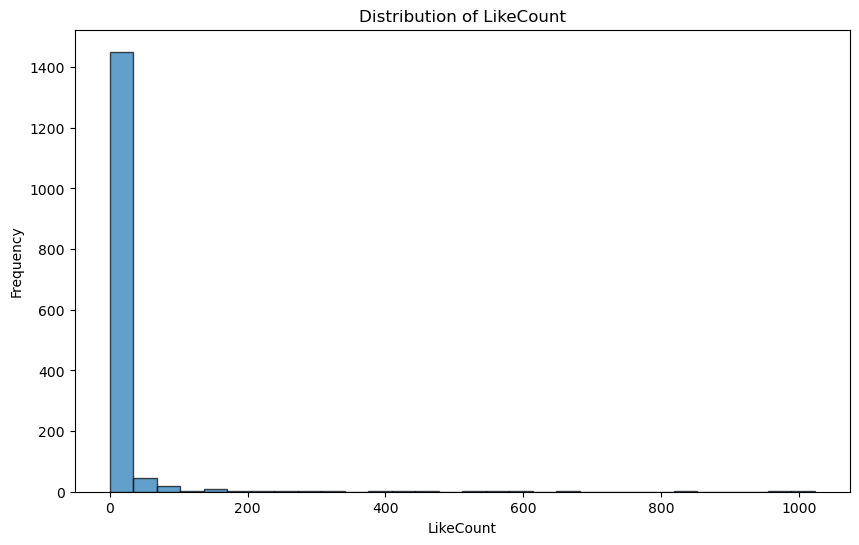

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(youtube_olympics_comments_english['LikeCount'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of LikeCount')
plt.xlabel('LikeCount')
plt.ylabel('Frequency')
plt.show()

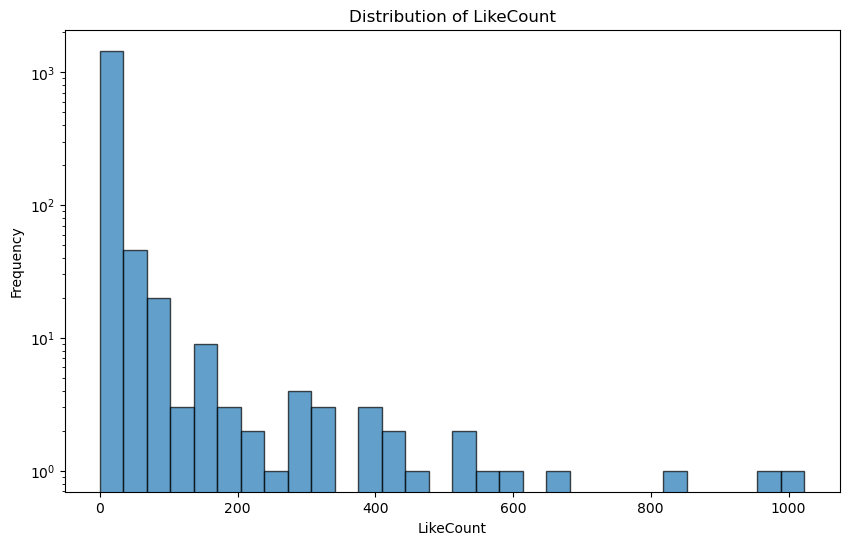

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(youtube_olympics_comments_english['LikeCount'], bins=30, edgecolor='k', alpha=0.7,log=True)
plt.title('Distribution of LikeCount')
plt.xlabel('LikeCount')
plt.ylabel('Frequency')
plt.show()

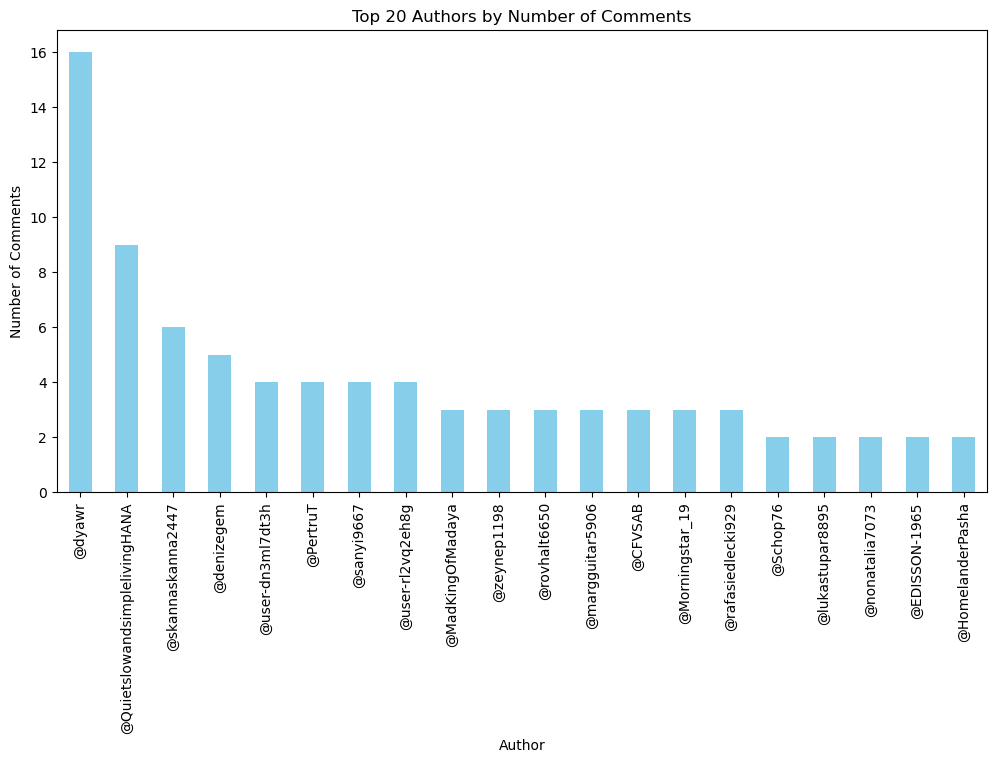

In [55]:
author_counts = youtube_olympics_comments_english['Author'].value_counts().head(20)  # Display top 20 authors for readability
plt.figure(figsize=(12, 6))
author_counts.plot(kind='bar', color='skyblue')
plt.title('Top 20 Authors by Number of Comments')
plt.xlabel('Author')
plt.ylabel('Number of Comments')
plt.show()

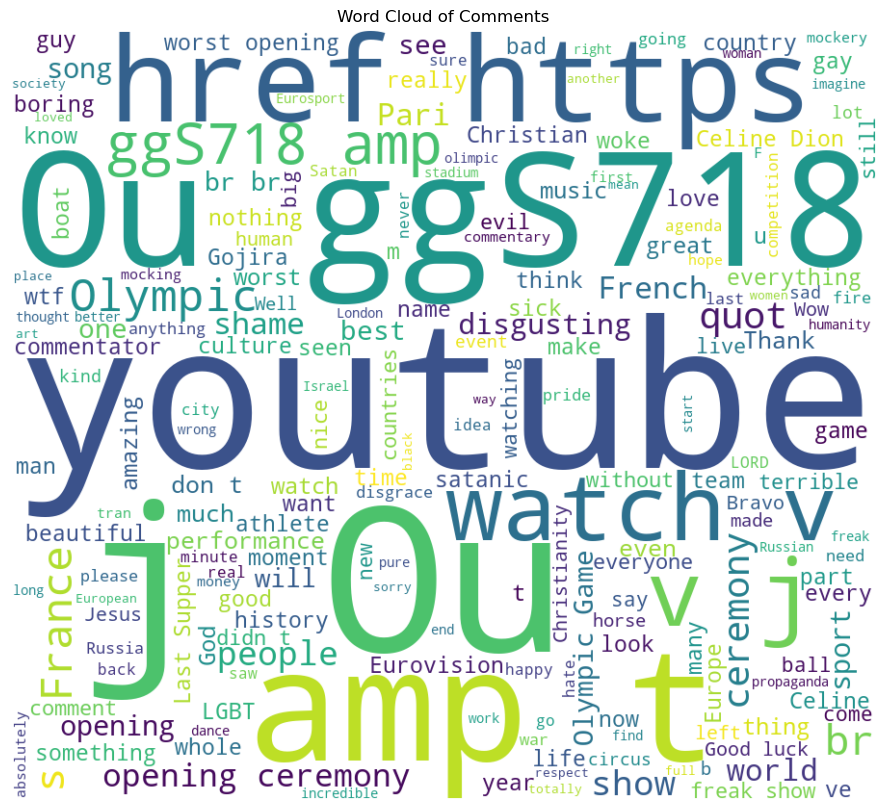

In [70]:
# generate a word cloud
all_comments = ' '.join(youtube_olympics_comments_english['Comment'])
wordcloud = WordCloud(width=900, height=800, background_color='white').generate(all_comments)

# display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()


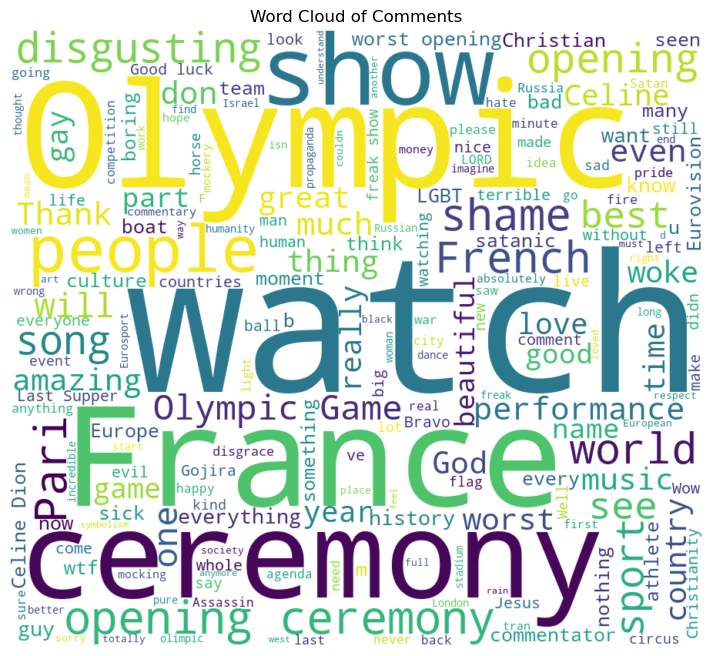

In [354]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['amp', 'youtube', 'https','href','ggs718',"j",'ou','t','quot','v','s','br']) 

all_comments = ' '.join(youtube_olympics_comments_english['Comment'])
wordcloud = WordCloud(width=900, height=800, background_color='white', stopwords=custom_stopwords).generate(all_comments)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

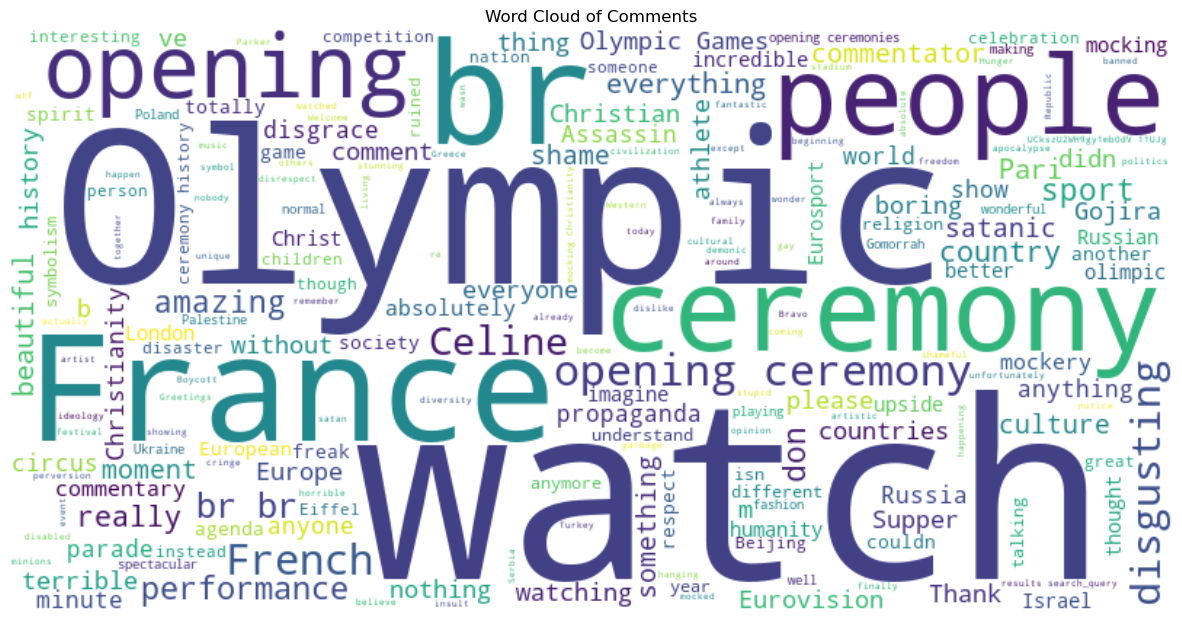

In [348]:
# Combine all comments into a single string
all_comments = ' '.join(df['Comment'])

# Remove one-letter words
filtered_comments = ' '.join([word for word in all_comments.split() if len(word) > 5])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(filtered_comments)

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

In [388]:

youtube_olympics_comments_english['TruncatedComment'] = youtube_olympics_comments_english ['Comment'].astype(str).apply(lambda x: x[:500])

In [390]:
df = youtube_olympics_comments_english



df['TruncatedComment'] = df['Comment'].apply(lambda x: x[:500])

# initialize the sentiment-analysis pipeline
sentiment_pipeline = pipeline(
    'sentiment-analysis',
    model='distilbert-base-uncased-finetuned-sst-2-english'  
)

# get sentiment score using Hugging Face's transformers
def get_transformer_sentiment(comment):
    result = sentiment_pipeline(comment)[0]
    # Convert 'POSITIVE' and 'NEGATIVE' labels to polarity scores
    return result['score'] if result['label'] == 'POSITIVE' else -result['score']

# calc sentiment for each truncated comment
df['Sentiment'] = df['TruncatedComment'].apply(get_transformer_sentiment)



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [430]:
# create a new column for sentiment categories
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

youtube_olympics_comments_english['SentimentCategory'] = youtube_olympics_comments_english['Sentiment'].apply(categorize_sentiment)


In [432]:
youtube_olympics_comments_english

,Comment,Author,PublishedAt,LikeCount,TruncatedComment,Sentiment,SentimentCategory,CommentLength
0,Boycotting the Olympics! Drag degenerate show ...,@edgarsdzerins,2024-07-28 09:44:42+00:00,0,Boycotting the Olympics! Drag degenerate show ...,-0.999647,Negative,61
1,THIS IS A DEMORALISATION PSYOP. BOTH DE-MORAL-...,@Bd-ng1zv,2024-07-28 09:43:58+00:00,0,THIS IS A DEMORALISATION PSYOP. BOTH DE-MORAL-...,-0.998880,Negative,68
2,"Worst opening ever to be created, the world go...",@yanomosh123,2024-07-28 09:43:18+00:00,0,"Worst opening ever to be created, the world go...",-0.999807,Negative,54
3,the internationalist banker sect is strong wit...,@Bd-ng1zv,2024-07-28 09:43:04+00:00,0,the internationalist banker sect is strong wit...,0.999015,Positive,59
4,Satanic games. My country should not be there.,@user-gl1tc7wi8g,2024-07-28 09:40:05+00:00,0,Satanic games. My country should not be there.,-0.999639,Negative,46
...,...,...,...,...,...,...,...,...
1551,The silver horse,@CFVSAB,2024-07-26 21:36:33+00:00,21,The silver horse,0.999493,Positive,16
1552,My god Celine what was that?,@CFVSAB,2024-07-26 21:36:14+00:00,1,My god Celine what was that?,-0.988289,Negative,28
1553,"<a href=""https://www.youtube.com/watch?v=j-Ou-...",@SocialClout,2024-07-26 21:34:50+00:00,44,"<a href=""https://www.youtube.com/watch?v=j-Ou-...",0.998843,Positive,97
1554,Damn that was probably the most impressive ope...,@shugielov,2024-07-26 21:34:33+00:00,40,Damn that was probably the most impressive ope...,0.999750,Positive,78


In [434]:
youtube_olympics_comments_english.groupby('SentimentCategory').size().reset_index(name='Count').sort_values(by='SentimentCategory')

,SentimentCategory,Count
0,Negative,1080
1,Positive,476


The most liked comment is negative

In [395]:
youtube_olympics_comments_english.nlargest(1, 'LikeCount')[['Comment', 'LikeCount', 'SentimentCategory']]


,Comment,LikeCount,SentimentCategory
711,Please don&#39;t leave any more bad comments b...,1023,Negative


In [396]:
##most_comments_user = youtube_olympics_comments_english['Author'].value_counts().idxmax()

In [397]:
##youtube_olympics_comments_english[youtube_olympics_comments_english['Author'] == most_comments_user]

Below is the distribution of sentiment

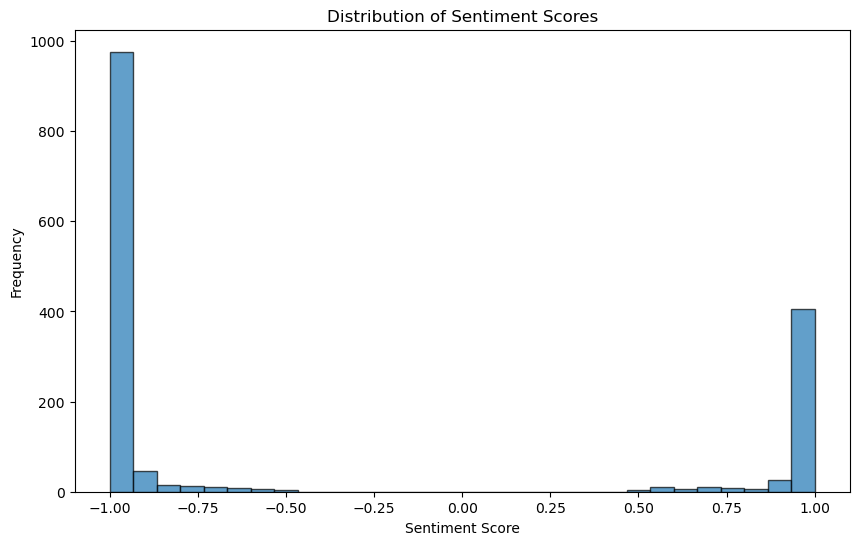

In [399]:
plt.figure(figsize=(10, 6))
plt.hist(youtube_olympics_comments_english['Sentiment'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

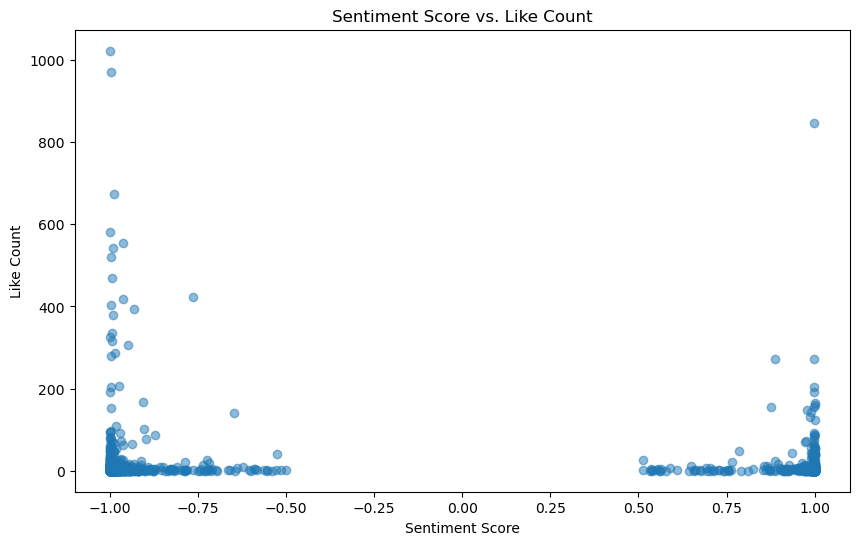

In [400]:
plt.figure(figsize=(10, 6))
plt.scatter(youtube_olympics_comments_english['Sentiment'], youtube_olympics_comments_english['LikeCount'], alpha=0.5)
plt.title('Sentiment Score vs. Like Count')
plt.xlabel('Sentiment Score')
plt.ylabel('Like Count')
plt.show()


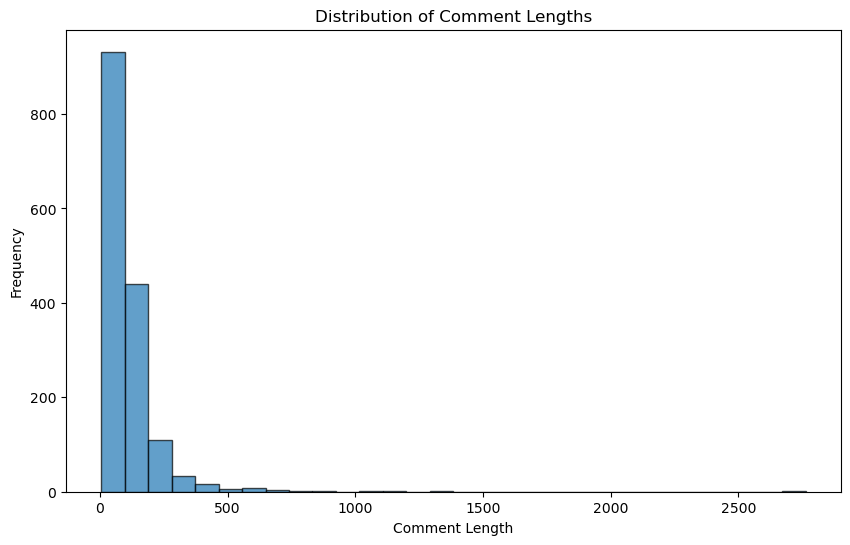

In [401]:
youtube_olympics_comments_english['CommentLength'] = youtube_olympics_comments_english['Comment'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(youtube_olympics_comments_english['CommentLength'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()


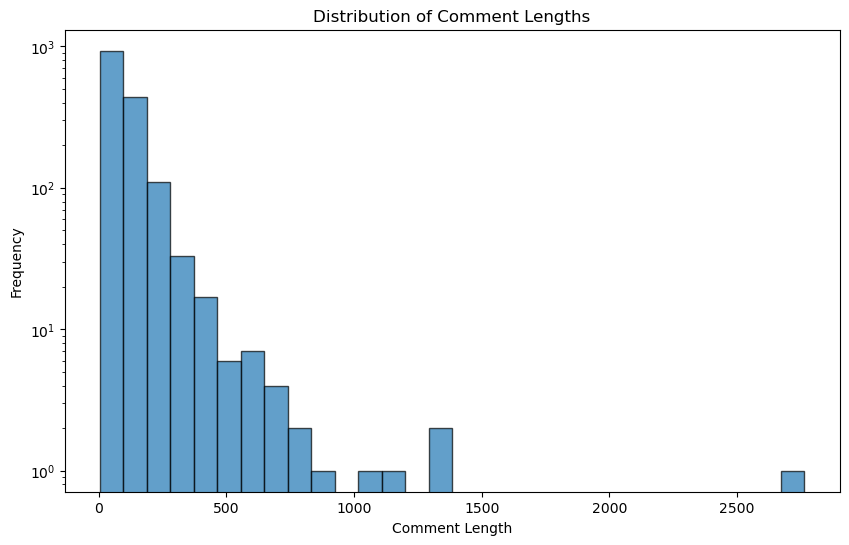

In [402]:
youtube_olympics_comments_english['CommentLength'] = youtube_olympics_comments_english['Comment'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(youtube_olympics_comments_english['CommentLength'], bins=30, edgecolor='k', alpha=0.7,log=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

In [403]:
youtube_olympics_comments_english[youtube_olympics_comments_english['CommentLength'] > 2500]

,Comment,Author,PublishedAt,LikeCount,TruncatedComment,Sentiment,SentimentCategory,CommentLength
1143,"My favourite moments <br><a href=""https://www....",@tilaNmanx,2024-07-27 08:17:41+00:00,316,"My favourite moments <br><a href=""https://www....",-0.992976,Negative,2763


In [404]:
youtube_olympics_comments_english[youtube_olympics_comments_english['CommentLength'] < 8]

,Comment,Author,PublishedAt,LikeCount,TruncatedComment,Sentiment,SentimentCategory,CommentLength
217,So sick,@milenasavic6662,2024-07-28 01:57:40+00:00,5,So sick,-0.999743,Negative,7
253,Cringe,@Demetttttt,2024-07-28 00:12:14+00:00,2,Cringe,-0.999702,Negative,6
392,Wtf...,@SigfridSWE,2024-07-27 20:59:48+00:00,0,Wtf...,-0.711860,Negative,6
538,Chore,@elaczajka1502,2024-07-27 18:48:01+00:00,0,Chore,-0.995297,Negative,5
974,Poverty,@Alfrad-mw3pp,2024-07-27 11:02:47+00:00,0,Poverty,-0.999635,Negative,7
1043,cringe,@bogclips850,2024-07-27 09:55:39+00:00,0,cringe,-0.999702,Negative,6
